# 1 Import Libraries and Packages 

In [1]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from datetime import datetime, timedelta, date
from prophet import Prophet
from neuralprophet import NeuralProphet
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.exponential_smoothing import ets
from statsmodels.tools.eval_measures import rmse, mse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Importing plotly failed. Interactive plots will not work.


In [2]:
user = os.getenv("USER")

# 2 Import the dataset and check the columns

In [3]:
#Import the dataset

data = pd.read_csv(f"/Users/{user}/forecasting-part-two/victoria_covid_cases_source_updated.csv", date_parser=True)

In [4]:
print(data.shape) #Getting the shape of the data
data.head()

(21693, 4)


,diagnosis_date,Postcode,acquired,Localgovernmentarea
0,2020-03-11,3216,Travel overseas,Greater Geelong (C)
1,2020-03-08,3942,Travel overseas,Mornington Peninsula (S)
2,2020-03-09,3206,Travel overseas,Port Phillip (C)
3,2020-08-01,3754,Contact with a confirmed case,Whittlesea (C)
4,2020-03-01,3802,Travel overseas,Casey (C)


In [5]:
#Getting all the dates between, since there is a chance some dates in between are missing
full_dates = pd.date_range(start=data.diagnosis_date.min(),
              end=data.diagnosis_date.max())
full_dates = pd.to_datetime(full_dates, format="%Y-%m-%d")
print(full_dates.shape)

(579,)


In [6]:
#Aggregating the data, and getting daily cases
vic_cases = data.groupby(["diagnosis_date"]).agg({"Postcode":"count"})\
                .rename(columns={"Postcode":"total_cases"})
#Formatting the index
vic_cases.index = pd.to_datetime(vic_cases.index, format='%Y-%m-%d')

#Filling the missing dates
vic_cases = vic_cases.reindex(full_dates,fill_value=0)

#print the shape
print(vic_cases.shape)

vic_cases.head()

(579, 1)


,total_cases
2020-01-25,1
2020-01-26,0
2020-01-27,0
2020-01-28,1
2020-01-29,0


In [7]:
#updating the date from object datatype to date datatype 
vic_cases.index.asfreq = "d" #adding the frequency to daily

# 3 Explore the data

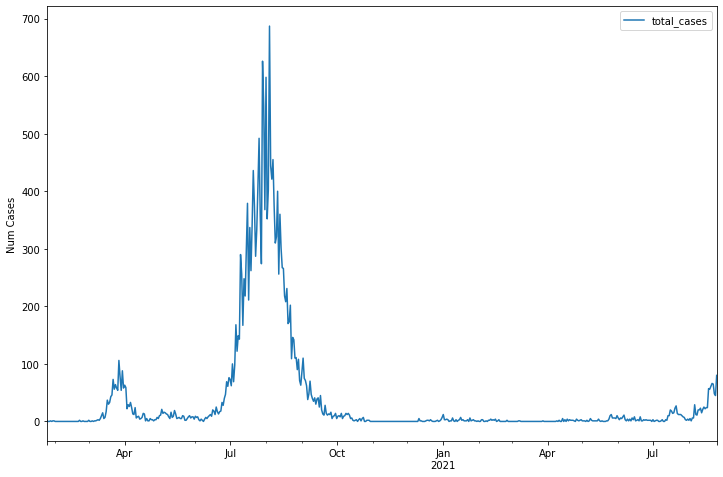

In [8]:
#Chaging the figsize
plt.rcParams["figure.figsize"] = (12,8)

#Lets the plot the data
vic_cases.plot()
plt.ylabel("Num Cases");

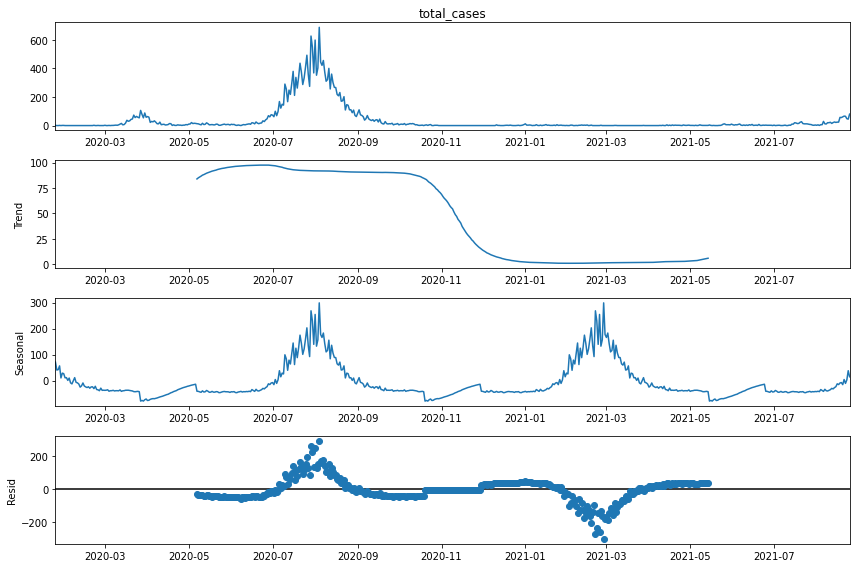

In [9]:
#Lets apply the Seasonal decomposition
results = seasonal_decompose(vic_cases["total_cases"], period=207)
results.plot();

# 4 Find the AR, MA, I values using plots and do some statistical tests

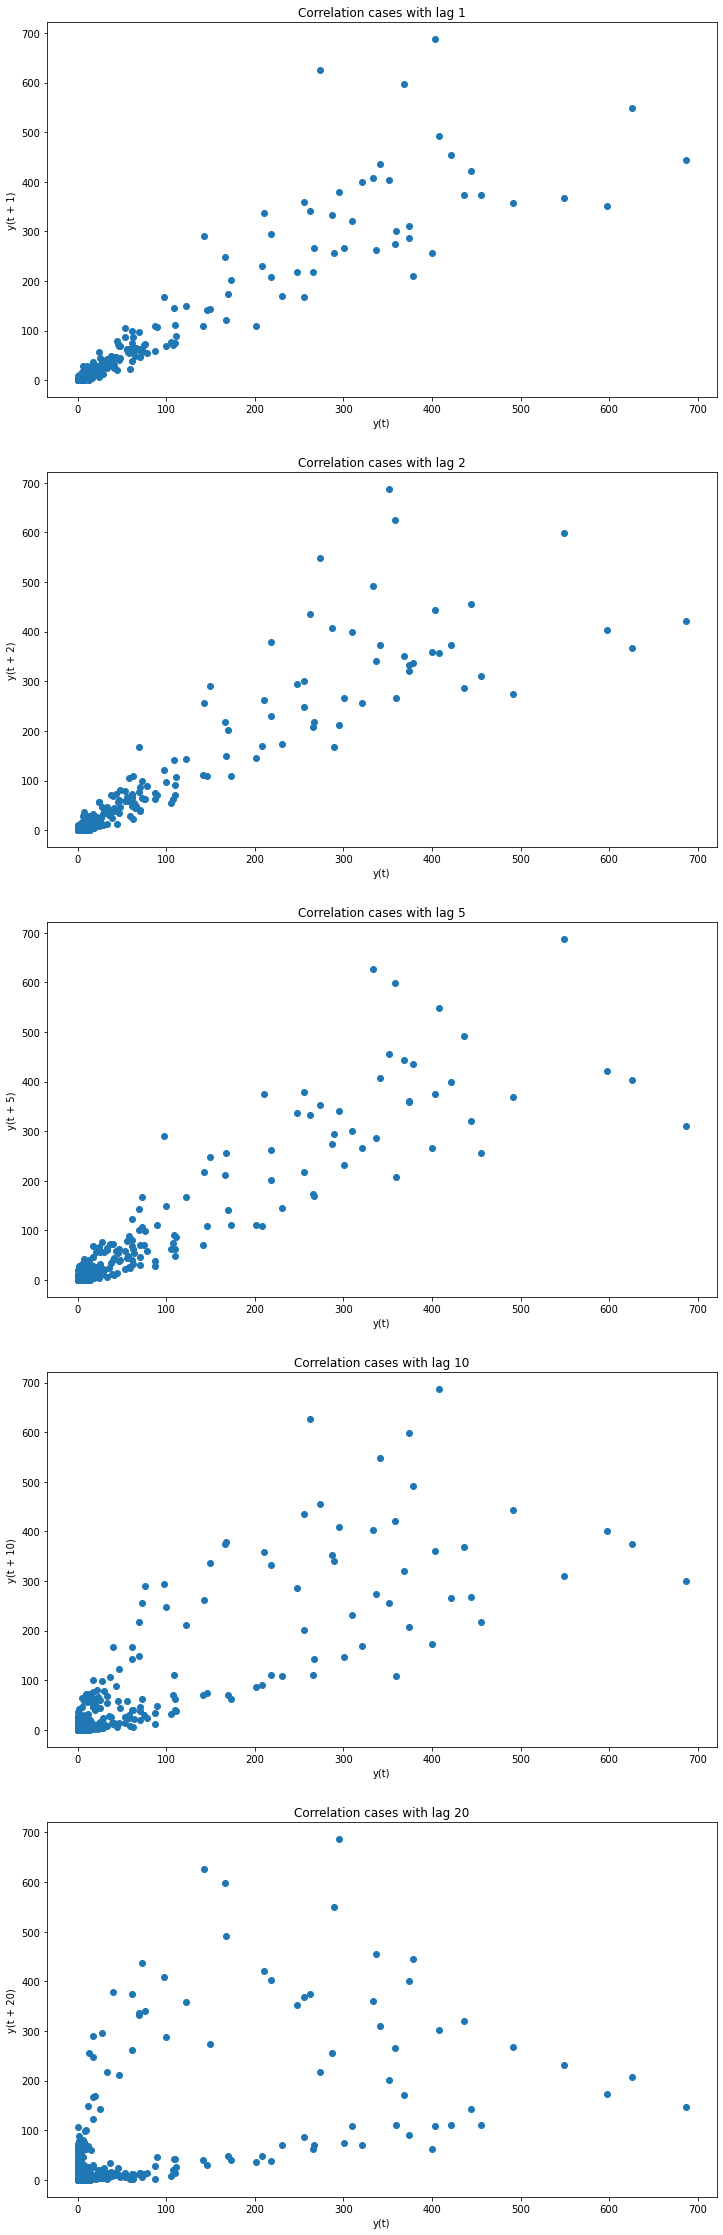

In [10]:
#Lets check if our lags are correlated
total_lags = [1, 2, 5, 10, 20]
fig, axes = plt.subplots(nrows=len(total_lags), ncols=1, figsize=(12,40))
index=0
for lg in total_lags:
    pd.plotting.lag_plot(vic_cases["total_cases"], lag=lg, ax=axes[index]);
    axes[index].set_title(f"Correlation cases with lag {lg}")
    index+=1

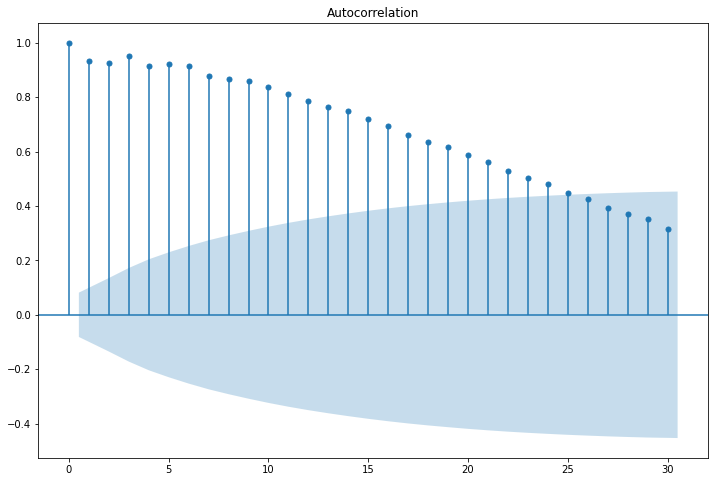

In [11]:
#Lets make it easier and use acf plot, and use this to get the value for AR side of the model
plot_acf(vic_cases['total_cases'],lags=30);

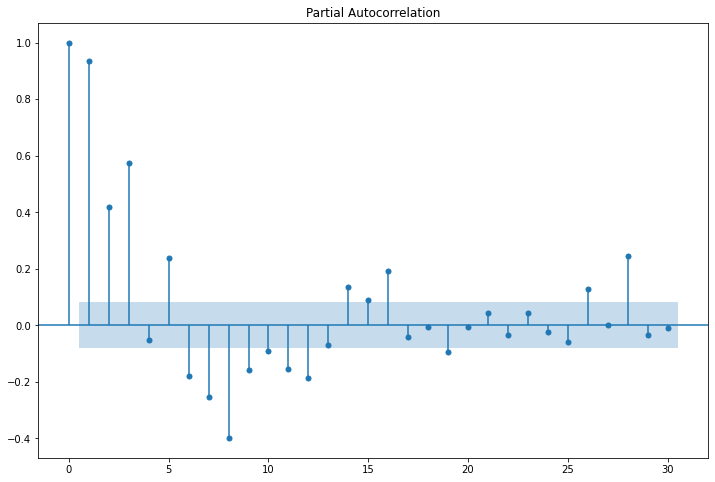

In [12]:
#Lets make it easier and use pacf plot, and use this to get the value for MA side of the model
plot_pacf(vic_cases['total_cases'],lags=30);

In [13]:
#Let check if data is stationary, if value is below 0.05, we can determine data is stationary
def adf_fuller_df(df, colname=""):
    """"The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
        root, which means there is a trend component, with the alternative that 
        there is no unit root, hence no trend component. If the pvalue is above 
        a critical size, then we cannot reject that there is a unit root."""

    df = df.copy()
    vals = adfuller(df[colname])
    first_columns = ["adf", "p-value", "usedlags", "number of observations"]
    other_column = "icbest"
    df = pd.DataFrame(data=pd.Series(vals[0:4], index=first_columns)).T
    for key, val in vals[4].items():
        df[f"Critical value for {key}"] = val
    df[other_column] = vals[5]
    p_value = df["p-value"][0]
    if  p_value <= 0.05:
        print(f"""We should reject the null hypothesis, since there is enough 
        evidence series is stationary, as there is only {np.round(p_value*100,2)} percent
        likelihood, that series is not stationary, and is very small""")
    else:
        print("We should further difference the series with itself ")
    
    return df

In [14]:
adf_fuller_df(vic_cases, "total_cases")

We should reject the null hypothesis, since there is enough 
        evidence series is stationary, as there is only 0.97 percent
        likelihood, that series is not stationary, and is very small


,adf,p-value,usedlags,number of observations,Critical value for 1%,Critical value for 5%,Critical value for 10%,icbest
0,-3.440002,0.009668,16.0,562.0,-3.442039,-2.866697,-2.569516,5100.60802


In [15]:
#Can we use auto arima instead to get all values of AR, I and MA
# Based on the plots, we could say AR can be max 21, MA could be max 3 and I is 0

# 5 Run auto arima to find out values for AR, MA and I side of the modes

In [16]:
auto_arima_model = auto_arima(vic_cases["total_cases"],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5393.634, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5745.943, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5631.636, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5530.370, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5743.952, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5492.721, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5409.949, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5395.523, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5346.987, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5349.849, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5317.100, Time=0.42 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5316.711, Time=0.48 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5391.251, Time=0.47 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5299.498, Time=0.66 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  579
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2639.821
Date:                Fri, 27 Aug 2021   AIC                           5295.641
Time:                        09:11:27   BIC                           5330.518
Sample:                             0   HQIC                          5309.241
                                - 579                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4367      0.028     15.667      0.000       0.382       0.491
ar.L2         -0.3135      0.019    -16.257      0.000      -0.351      -0.276
ar.L3          0.4610      0.013     34.165      0.000       0.435       0.487
ar.L4         -0.2133      0.018    -11.808      0.000      -0.249      -0.178
ar.L5          0.4099      0.012     33.300      0.000       0.386       0.434
ma.L1         -1.1582      0.031    -36.864      0.000      -1.220      -1.097
ma.L2          0.4025      0.028     14.489      0.000       0.348       0.457
sigma2       540.4752      8.761     61.694      0.000     523.305     557.646
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22958.65
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 6 Lets split the data into training and Test

In [17]:
#Lets split the data into train and testing
train = vic_cases[:"2021-08-20"]
test = vic_cases["2021-08-21":]

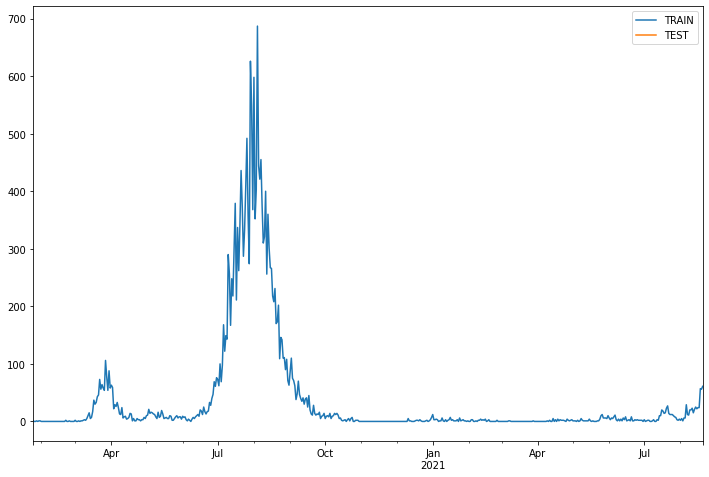

In [18]:
ax = train.plot()
ax.plot(test)
ax.legend(["TRAIN", "TEST"]);

In [19]:
auto_arima_model = auto_arima(train["total_cases"],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5350.435, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5699.981, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5586.349, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5485.939, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5697.986, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5448.808, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5366.443, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5352.334, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5303.049, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5306.063, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5273.359, Time=0.64 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5272.959, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5347.961, Time=0.42 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5255.268, Time=0.64 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  574
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2617.712
Date:                Fri, 27 Aug 2021   AIC                           5251.424
Time:                        09:11:36   BIC                           5286.231
Sample:                             0   HQIC                          5265.001
                                - 574                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4376      0.028     15.873      0.000       0.384       0.492
ar.L2         -0.3149      0.019    -16.342      0.000      -0.353      -0.277
ar.L3          0.4605      0.014     33.980      0.000       0.434       0.487
ar.L4         -0.2132      0.018    -11.806      0.000      -0.249      -0.178
ar.L5          0.4123      0.012     33.175      0.000       0.388       0.437
ma.L1         -1.1619      0.031    -37.363      0.000      -1.223      -1.101
ma.L2          0.4081      0.027     14.882      0.000       0.354       0.462
sigma2       541.7994      8.808     61.511      0.000     524.536     559.063
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22923.83
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 7 Train the model based on ARIMA terms from Auto arima

In [20]:
#train the data based on the parameters we got
arima_model = ARIMA(train["total_cases"], order=(5,1,2)).fit()
arima_model.summary()

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  574
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2617.712
Date:                Fri, 27 Aug 2021   AIC                           5251.424
Time:                        09:11:37   BIC                           5286.231
Sample:                    01-25-2020   HQIC                          5265.001
                         - 08-20-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4376      0.028     15.873      0.000       0.384       0.492
ar.L2         -0.3149      0.019    -16.342      0.000      -0.353      -0.277
ar.L3          0.4605      0.014     33.980      0.000       0.434       0.487
ar.L4         -0.2132      0.018    -11.806      0.000      -0.249      -0.178
ar.L5          0.4123      0.012     33.175      0.000       0.388       0.437
ma.L1         -1.1619      0.031    -37.363      0.000      -1.223      -1.101
ma.L2          0.4081      0.027     14.882      0.000       0.354       0.462
sigma2       541.7994      8.808     61.511      0.000     524.536     559.063
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22923.83
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 8 Make predictions

In [21]:
#Predict the model
start = train.shape[0] 
end = train.shape[0] + test.shape[0] - 1
arima_predictions = arima_model.predict(start=start, end=end)

In [22]:
results=test
test["predictions"] = [p for p in arima_predictions]

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_8497/4087890050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = [p for p in arima_predictions]


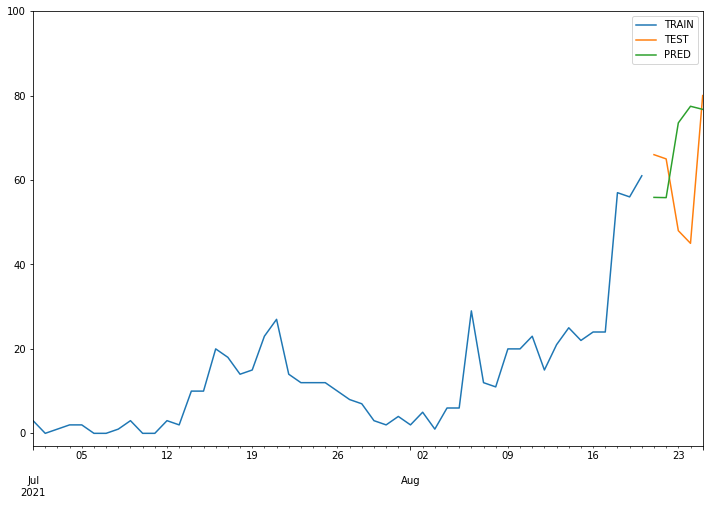

In [23]:
#plotting the results
ax = train.plot()
ax.plot(test["total_cases"])
ax.plot(test["predictions"])
ax.set_xlim(date(2021,7,1),date(2021,8,25))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED"]);

# 9 Evaluate the model

In [24]:
#measure performance
RMSE=rmse(results.total_cases, results.predictions)
MSE=mse(results.total_cases, results.predictions)

print(f"rmse is {RMSE}")
print(f"mse is {MSE}")
print("mean is {}".format(test.total_cases.mean()))

rmse is 19.50897101998656
mse is 380.59995025867545
mean is 60.8


# 10 Lets try model building training, testing with Fb Prophet Library

In [25]:
#The library like dates in DS column and target variable in Y
vic_cases = vic_cases.reset_index()
vic_cases = vic_cases.rename(columns={"total_cases":"y", "index":"ds"})
vic_cases.head()

,ds,y
0,2020-01-25,1
1,2020-01-26,0
2,2020-01-27,0
3,2020-01-28,1
4,2020-01-29,0


In [26]:
#splitting data into training and testing
trainX=vic_cases[:-test.shape[0]]
textX=vic_cases[-test.shape[0]:]

In [27]:
#Train the model

#Define the model
fb_model=Prophet()

#Fit the model
fb_model.fit(trainX)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.24784
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         935.1     0.0276485         125.4       3.634      0.3634      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       940.709   2.34704e-05       64.9226   3.987e-07       0.001      285  LS failed, Hessian reset 
     199        940.71   2.31262e-06       60.5242           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220        940.71   8.93585e-07       72.7818   1.217e-08       0.001      382  LS failed, Hessian reset 
     226        940.71   2.14217e-08       49.8819     0.03049           1      393   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [28]:
#future dates
future = fb_model.make_future_dataframe(periods=test.shape[0])
future.tail(test.shape[0])

,ds
574,2021-08-21
575,2021-08-22
576,2021-08-23
577,2021-08-24
578,2021-08-25


In [29]:
#forecast
fb_predictions=fb_model.predict(future)
fb_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])


,ds,yhat,yhat_lower,yhat_upper
574,2021-08-21,9.502062,-78.970159,94.830170
575,2021-08-22,2.941429,-87.469437,95.425881
576,2021-08-23,5.590955,-85.558466,92.445898
577,2021-08-24,9.387888,-80.533903,100.588793
578,2021-08-25,9.898287,-86.610235,106.783108


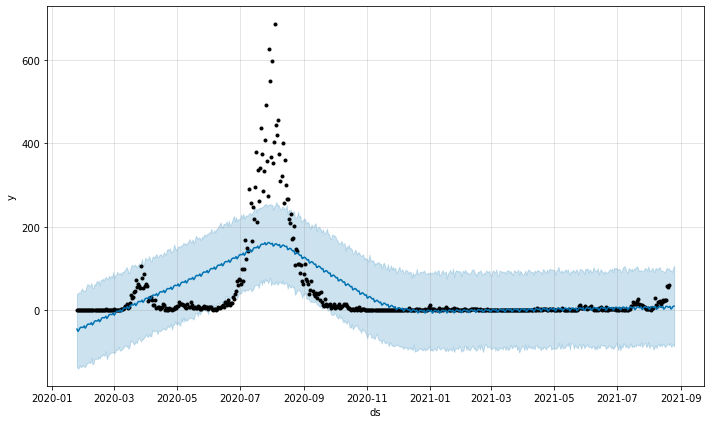

In [30]:
#plot the data
fig1 = fb_model.plot(fb_predictions)


In [31]:
train.total_cases = train.total_cases.astype(float)
test.total_cases = test.total_cases.astype(float)

In [32]:
ets_model = ets.ETSModel(train['total_cases'], freq='D', error='add').fit()
predictions_ets = ets_model.predict(start=start, end=end)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.20254D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.96941D+00    |proj g|=  4.27792D-01

At iterate    2    f=  4.82625D+00    |proj g|=  3.23352D-01

At iterate    3    f=  4.78064D+00    |proj g|=  1.93677D-02

At iterate    4    f=  4.78058D+00    |proj g|=  9.76996D-05

At iterate    5    f=  4.78058D+00    |proj g|=  2.66454D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      7     0     0   

In [33]:
fb_pred = fb_predictions[["ds","yhat"]][-test.shape[0]:]
fb_pred.set_index("ds", inplace=True)

In [34]:
fb_pred

521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


,yhat
ds,
2021-08-21,9.502062
2021-08-22,2.941429
2021-08-23,5.590955
2021-08-24,9.387888
2021-08-25,9.898287


# 11 Create ensemble of three models and visualise the results

In [35]:
#Ensemble predictions
ensemble = (fb_pred.yhat + predictions_ets + test.predictions)/3

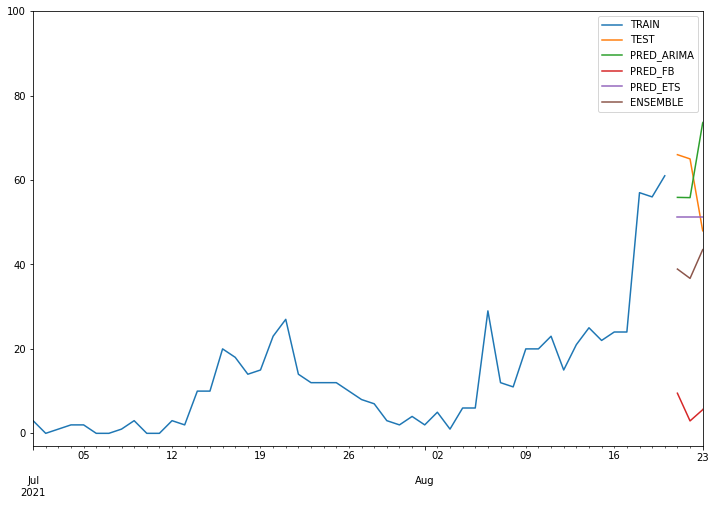

In [36]:
ax = train.plot()
ax.plot(test["total_cases"])
ax.plot(test["predictions"])
ax.plot(fb_pred['yhat'])
ax.plot(predictions_ets)
ax.plot(ensemble)
ax.set_xlim(date(2021,7,1),date(2021,8,23))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED_ARIMA","PRED_FB", "PRED_ETS","ENSEMBLE"]);

# 12 Add some exogenous variables to the model and try make better predictions

In [37]:
#Adding some features
vic_cases_wf = data[["diagnosis_date","acquired","Postcode"]].pivot_table(index="diagnosis_date", columns="acquired", values="Postcode", aggfunc="count", fill_value=0)
vic_cases_wf["Community"] = vic_cases_wf["Contact with a confirmed case"] + vic_cases_wf["Under investigation"]
vic_cases_wf["lockdown"] = vic_cases_wf.Community.apply(lambda val: 1 if val >= 10 else 0)

#Formatting the index
vic_cases_wf.index = pd.to_datetime(vic_cases_wf.index, format='%Y-%m-%d')

#Filling the missing dates
vic_cases_wf = vic_cases_wf.reindex(full_dates,fill_value=0)
vic_cases_wf.index.rename("index", inplace=True)

#Adding the delta feature
vic_cases_wf["delta"] = vic_cases_wf.index.map(lambda val : 1 if val >= date(2021,6,1) else 0 )

#print the shape
print(vic_cases_wf.shape)

vic_cases_wf.head()

(579, 7)


/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_8497/1487443330.py:14: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  vic_cases_wf["delta"] = vic_cases_wf.index.map(lambda val : 1 if val >= date(2021,6,1) else 0 )


acquired,"Acquired in Australia, unknown source",Contact with a confirmed case,Travel overseas,Under investigation,Community,lockdown,delta
index,,,,,,,
2020-01-25,0,0,1,0,0,0,0
2020-01-26,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0
2020-01-28,0,0,1,0,0,0,0
2020-01-29,0,0,0,0,0,0,0


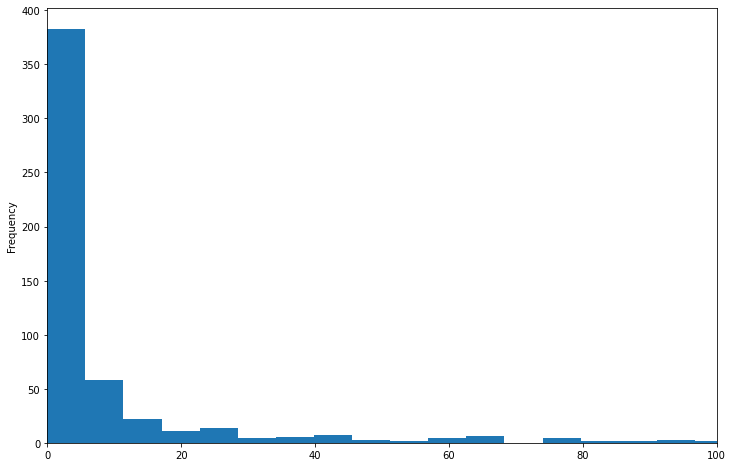

In [38]:
#Lets visualise number of common cases
vic_cases_wf.Community.plot.hist(bins=100)
plt.xlim(0,100);

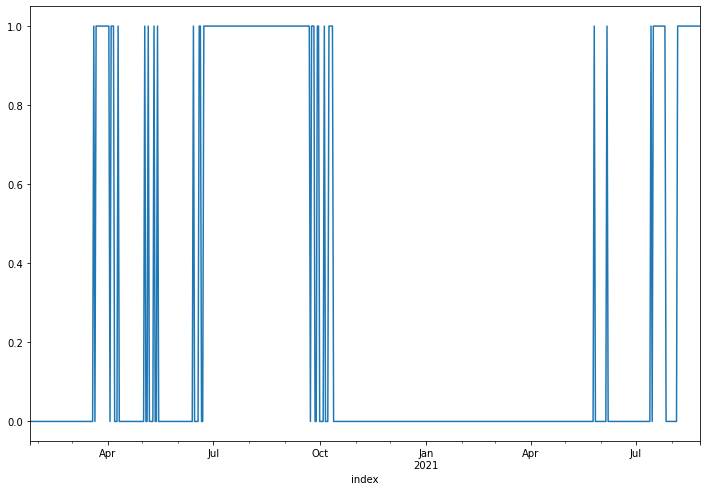

In [39]:
#Plotting the lockdown
vic_cases_wf.lockdown.plot();

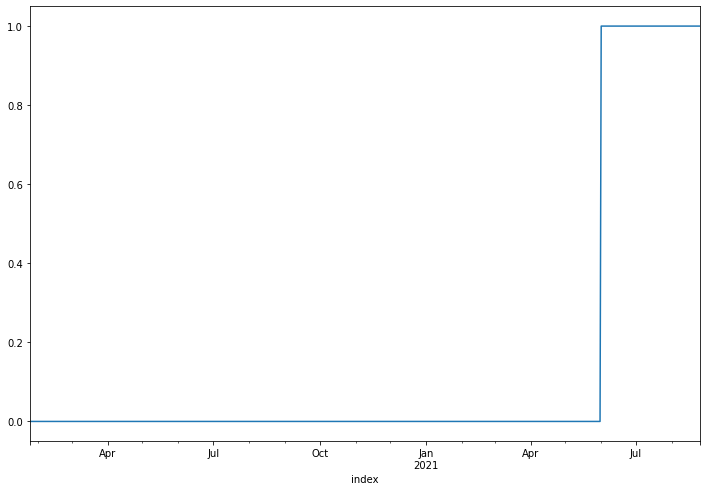

In [40]:
#Plotting delta
vic_cases_wf.delta.plot();

In [41]:
#features to include in the model
features = ["delta","lockdown"]

In [42]:
#Subsetting the data
vic_cases_wf_final = vic_cases_wf[features]
vic_cases_wf_final = vic_cases_wf_final.reset_index()\
                                       .merge(vic_cases, left_on="index", right_on="ds")\
                                       .drop(["index"],1)
vic_cases_wf_final.set_index("ds", inplace=True)
vic_cases_wf_final.head()

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_8497/634819455.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  vic_cases_wf_final = vic_cases_wf_final.reset_index()\


,delta,lockdown,y
ds,,,
2020-01-25,0,0,1
2020-01-26,0,0,0
2020-01-27,0,0,0
2020-01-28,0,0,1
2020-01-29,0,0,0


In [43]:
#Lets split the data into train and testing
train = vic_cases_wf_final[:"2021-08-20"]
test = vic_cases_wf_final["2021-08-21":]

In [44]:
auto_arima_model = auto_arima(train["y"],
                               X=train[features],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=True, 
                               random_state=42, #seed
                               n_fits=10,
                               m=7,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6616.654, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5677.463, Time=0.73 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=6087.414, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6619.505, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=5694.858, Time=0.23 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=5679.022, Time=1.77 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=5710.567, Time=0.74 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=5680.544, Time=0.72 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=6034.378, Time=0.44 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=5575.361, Time=1.00 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=5592.986, Time=0.46 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=5577.782, Time=1.59 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=5

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,1)(2,0,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,

 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=5500.468, Time=0.72 sec
 ARIMA(3,0,1)(1,0,0)[7] intercept   : AIC=5391.056, Time=1.16 sec
 ARIMA(3,0,1)(0,0,0)[7] intercept   : AIC=5391.576, Time=0.59 sec
 ARIMA(3,0,1)(2,0,0)[7] intercept   : AIC=5373.095, Time=2.17 sec
 ARIMA(3,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(3,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(3,0,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(4,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(3,0,2)(2,0,0)[7] intercept   : AIC=5477.926, Time=2.17 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(4,0,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(4,0,2)(2,0,0)[7] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(3,0,1)(2,0,0)[7]             : AIC=5371.216, Time=2.16 sec
 ARIMA(3,0,1)(1,0,0)[7]             : AIC=5389.139, Time=0.98 sec
 ARIMA(3,0,1)(2,0,1)[7]             : AIC=5378.475,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  574
Model:             SARIMAX(3, 0, 1)x(2, 0, [], 7)   Log Likelihood               -2676.608
Date:                            Fri, 27 Aug 2021   AIC                           5371.216
Time:                                    09:12:49   BIC                           5410.389
Sample:                                01-25-2020   HQIC                          5386.495
                                     - 08-20-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
delta        -35.6191     17.836     -1.997      0.046     -70.576      -0.662
lockdown       7.9948     12.475      0.641      0.522     -16.455      32.445
ar.L1          0.0738      0.020      3.781      0.000       0.036       0.112
ar.L2          0.2653      0.014     19.071      0.000       0.238       0.293
ar.L3          0.6609      0.011     57.511      0.000       0.638       0.683
ma.L1          0.3890      0.026     15.199      0.000       0.339       0.439
ar.S.L7       -0.0461      0.015     -3.057      0.002      -0.076      -0.017
ar.S.L14       0.1819      0.012     14.765      0.000       0.158       0.206
sigma2       643.5278     10.981     58.603      0.000     622.005     665.050
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):             14439.10
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
auto_arima_model = auto_arima(train["y"],
                               X=train[features],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6619.505, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5695.618, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6241.253, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5592.238, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5495.567, Time=0.56 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5495.449, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5462.319, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6154.518, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5321.073, Time=0.51 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5927.149, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5328.389, Time=0.64 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=5320.502, Time=0.62 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  574
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -2646.136
Date:                Fri, 27 Aug 2021   AIC                           5310.271
Time:                        09:13:02   BIC                           5349.445
Sample:                    01-25-2020   HQIC                          5325.551
                         - 08-20-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
delta          0.6586    116.697      0.006      0.995    -228.064     229.381
lockdown       8.6363     11.537      0.749      0.454     -13.976      31.248
ar.L1          0.9994      0.001    987.846      0.000       0.997       1.001
ma.L1         -0.7449      0.015    -48.777      0.000      -0.775      -0.715
ma.L2         -0.1778      0.018    -10.155      0.000      -0.212      -0.143
ma.L3          0.5152      0.013     38.352      0.000       0.489       0.541
ma.L4         -0.1640      0.015    -11.108      0.000      -0.193      -0.135
ma.L5          0.1682      0.016     10.681      0.000       0.137       0.199
sigma2       606.5264     11.155     54.371      0.000     584.662     628.390
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):             15659.85
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
#Train the models
sarmia_model_exog=SARIMAX(train["y"], exog=train[features],order=(3,0,1), seasonal_order=(2,0,0,7), freq="D", max_iter=200).fit()
arima_model_exog=ARIMA(train["y"], exog=train[features], order=(1,0,5)).fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37245D+00    |proj g|=  5.48470D-01


/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  5.11502D+00    |proj g|=  1.49322D-01

At iterate   10    f=  5.08618D+00    |proj g|=  8.42300D-03

At iterate   15    f=  5.07999D+00    |proj g|=  3.97161D-03

At iterate   20    f=  5.07441D+00    |proj g|=  4.31157D-02

At iterate   25    f=  4.96987D+00    |proj g|=  1.43687D-01

At iterate   30    f=  4.78014D+00    |proj g|=  2.03142D-01

At iterate   35    f=  4.75364D+00    |proj g|=  3.34734D-02

At iterate   40    f=  4.67919D+00    |proj g|=  1.13872D-01

At iterate   45    f=  4.66316D+00    |proj g|=  8.42983D-03

At iterate   50    f=  4.66308D+00    |proj g|=  1.41766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency info

In [47]:
sarima_exog_pred=sarmia_model_exog.predict(start=start, end=end, exog=test[features])
arima_exog_pred=arima_model_exog.predict(start=start, end=end, exog=test[features])

# 13 Visualise the predictions against actual data after retraining with variables

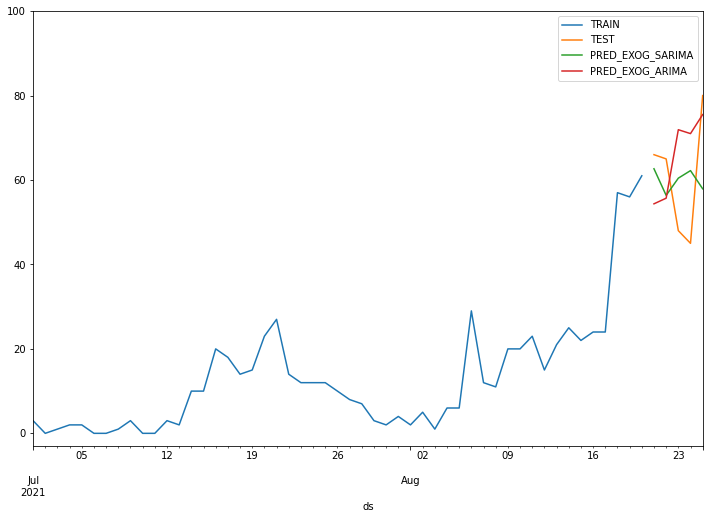

In [48]:
ax = train["y"].plot()
ax.plot(test["y"])
ax.plot(sarima_exog_pred)
ax.plot(arima_exog_pred)
ax.set_xlim(date(2021,7,1),date(2021,8,25))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED_EXOG_SARIMA","PRED_EXOG_ARIMA"]);

# 14 Adding variables to FB model and predicting in the future

In [49]:
#Prepare training and testing data for FB prophet
train = train.reset_index()
test = test.reset_index()
fb_train = train[["ds","y"] + features]
fb_test = test[["ds","y"] + features]

In [50]:
#Traing fb with exog variables
fb_model_exog = Prophet()
for _ in features:
    fb_model_exog.add_regressor(_)
fb_model_exog.fit(fb_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.24784
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       990.688   4.17349e-05       75.8804           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       990.692   4.78155e-08       71.3476      0.3413           1      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [51]:
#Lets make predictions for the model
fb_exog_future = fb_model_exog.make_future_dataframe(periods=test.shape[0])
for _ in features:
    fb_exog_future[_] = [val for val in vic_cases_wf_final[_]]
fb_exog_forecast = fb_model_exog.predict(fb_exog_future)
#forecast
fb_exog_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

,ds,yhat,yhat_lower,yhat_upper
574,2021-08-21,70.972702,-17.988357,165.256450
575,2021-08-22,61.864904,-34.613437,157.044218
576,2021-08-23,65.641877,-25.444648,158.736684
577,2021-08-24,73.089504,-11.518373,166.711714
578,2021-08-25,71.021920,-18.411442,163.945562


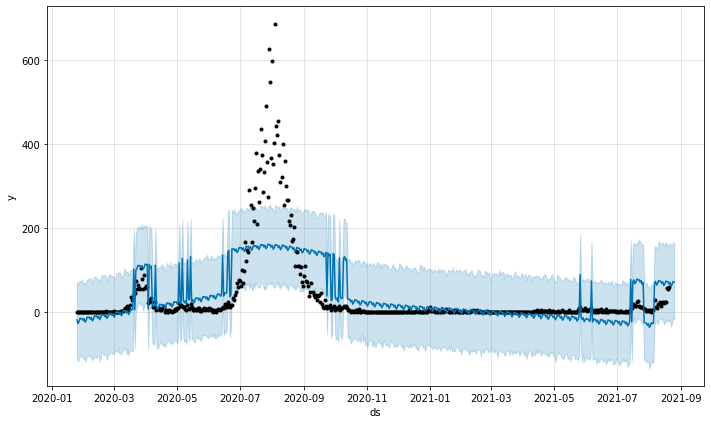

In [52]:
#plot the data
fig1 = fb_model_exog.plot(fb_exog_forecast)

In [53]:
#Ensemble predictions
fb_exog_pred = fb_exog_forecast[["ds","yhat"]][-test.shape[0]:]
fb_exog_pred.set_index("ds", inplace=True)
ensemble_exog = (fb_exog_pred.yhat + sarima_exog_pred + arima_exog_pred)/3
train.set_index("ds", inplace=True)
test.set_index("ds", inplace=True)

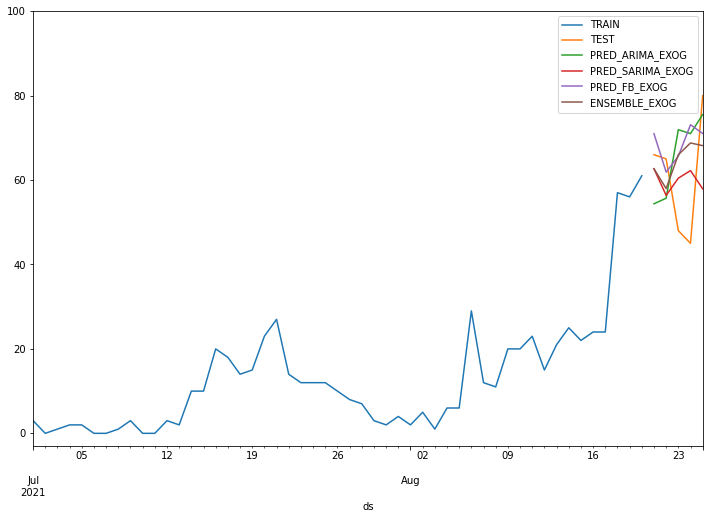

In [54]:
#Plotting all the models
ax = train["y"].plot()
ax.plot(test["y"])
ax.plot(arima_exog_pred)
ax.plot(sarima_exog_pred)
ax.plot(fb_exog_pred)
ax.plot(ensemble_exog)
ax.set_xlim(date(2021,7,1),date(2021,8,25))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED_ARIMA_EXOG","PRED_SARIMA_EXOG", "PRED_FB_EXOG","ENSEMBLE_EXOG"]);

# 15 Looking for seasonal component in model

In [55]:
#is there a seasonal component?
#Traing fb with exog variables
fb_model_exog_s = Prophet(daily_seasonality=True)
for _ in features:
    fb_model_exog_s.add_regressor(_)
fb_model_exog_s.fit(fb_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.24784


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       990.161    0.00138965       92.6575      0.2581           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       990.753    0.00115089       88.9408      0.3361           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        994.36   2.00478e-05       76.7323           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       994.791   0.000626882       107.991   7.676e-06       0.001      514  LS failed, Hessian reset 
     399       994.927   3.35399e-05       69.5307           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     412        994.93    2.5168e-09       63.7409   0.0002604      0.1401      5

In [56]:
#Lets make predictions for the model
fb_exog_future_s = fb_model_exog_s.make_future_dataframe(periods=test.shape[0])
for _ in features:
    fb_exog_future_s[_] = [val for val in vic_cases_wf_final[_]]
fb_exog_forecast_s = fb_model_exog.predict(fb_exog_future_s)
#forecast
fb_exog_forecast_s[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

,ds,yhat,yhat_lower,yhat_upper
574,2021-08-21,70.972702,-18.087950,172.124741
575,2021-08-22,61.864904,-27.204855,158.548788
576,2021-08-23,65.641877,-27.289244,150.019192
577,2021-08-24,73.089504,-13.992978,166.440818
578,2021-08-25,71.021920,-15.096500,167.438557


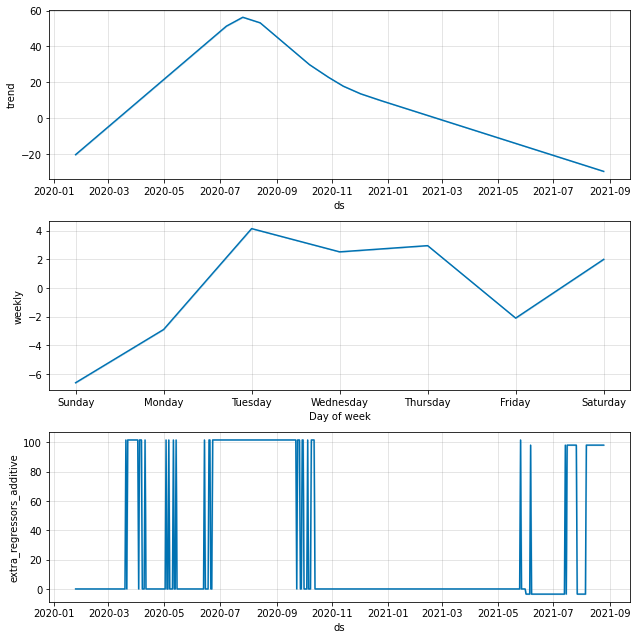

In [57]:
fb_model_exog_s.plot_components(fb_exog_forecast_s);

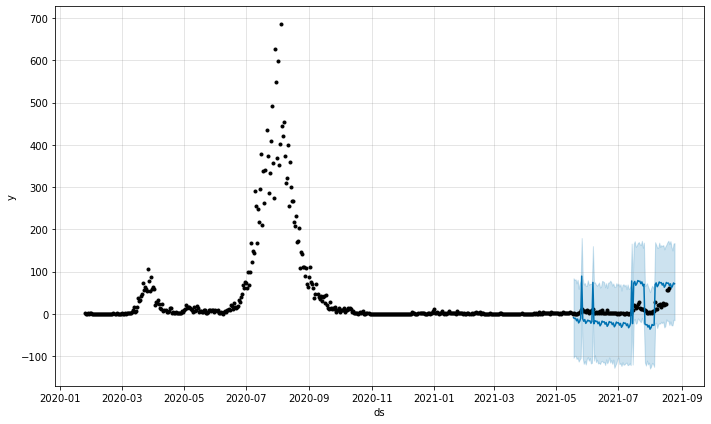

In [58]:
fb_model_exog_s.plot(fb_exog_forecast_s[-100:]);

In [59]:
fb_exog_forecast_s.set_index("ds", inplace=True)
RMSE = rmse(test["y"], fb_exog_forecast_s["yhat"][-test.shape[0]:])
print(f"RMSE in fb model is {RMSE}")

RMSE in fb model is 15.59114218319986


# 16 Lets forecast in the unknown future

In [60]:
#Lets do a forecast finally
arima_model_exog=ARIMA(vic_cases_wf_final["y"], exog=vic_cases_wf_final[features],order=(1,0,5)).fit()
sarima_model_exog=SARIMAX(vic_cases_wf_final["y"], exog=vic_cases_wf_final[features],order=(3,0,1), seasonal_order=(2,0,0,7)).fit()
fb_full = pd.concat([fb_train, fb_test], axis=0, ignore_index=True)
fb_model_exog_s = Prophet(daily_seasonality=True)
fb_model_exog_s.add_regressor("lockdown")
fb_model_exog_s.add_regressor("delta")
fb_model_exog_s.fit(fb_full)

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36593D+00    |proj g|=  5.50419D-01

At iterate    5    f=  5.11296D+00    |proj g|=  1.56441D-01

At iterate   10    f=  5.07945D+00    |proj g|=  1.13941D-02

At iterate   15    f=  5.07322D+00    |proj g|=  3.96812D-03

At iterate   20    f=  5.06887D+00    |proj g|=  4.17902D-02

At iterate   25    f=  4.89308D+00    |proj g|=  4.40666D-01

At iterate   30    f=  4.83180D+00    |proj g|=  8.30886D-02

At iterate   35    f=  4.74579D+00    |proj g|=  1.03676D-01

At iterate   40    f=  4.71290D+00    |proj g|=  4.67609D-02

At iterate   45    f=  4.66121D+00    |proj g|=  6.15235D-03

At iterate   50    f=  4.66102D+00    |proj g|=  1.48834D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.49093


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1002.06   0.000321461       78.2069           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1002.76   4.40874e-05       79.5874      0.3664           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     291       1005.12    0.00238901       256.298   2.372e-05       0.001      401  LS failed, Hessian reset 
     299        1005.4   0.000332005       69.4817      0.3083      0.3083      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1006.31   2.55735e-05       70.4531      0.4192      0.4192      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433        1006.4   0.000217857       70.1422   2.465e-06       0.001      6

In [61]:
#Lets make predictions for the model
fb_exog_future_s = fb_model_exog_s.make_future_dataframe(periods=test.shape[0])
for _ in features:
    fb_exog_future_s[_] = [val for val in vic_cases_wf_final[_]] + list(np.ones(test.shape[0]))
fb_exog_forecast_s = fb_model_exog.predict(fb_exog_future_s)
#forecast
fb_exog_forecast_s[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

06  LS failed, Hessian reset 
     499       1006.41   1.01507e-05       75.3076      0.9134      0.9134      699   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     502       1006.41   1.22097e-05         71.85     1.4e-07       0.001      737  LS failed, Hessian reset 
     521       1006.41    6.9896e-08       59.7842           1           1      763   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,yhat,yhat_lower,yhat_upper
579,2021-08-26,71.649223,-20.093065,158.944619
580,2021-08-27,65.808774,-25.950538,157.320608
581,2021-08-28,69.838804,-20.820635,159.470226
582,2021-08-29,60.731006,-28.258817,153.291053
583,2021-08-30,64.507979,-28.082263,162.904996


In [62]:
#Foreasting arima and sarima
arima_exog_future=fb_exog_forecast_s[["ds"]][-test.shape[0]:]

#Adding exogenous variables
for _ in features:
    arima_exog_future[_] = 1
arima_exog_future.set_index("ds", inplace=True)
start=vic_cases_wf_final.shape[0]
end=vic_cases_wf_final.shape[0] + test.shape[0] -1

#Forecasts
arima_exog_forecast = arima_model_exog.predict(start=start, end=end, exog=arima_exog_future[features])
sarima_exog_forecast = sarima_model_exog.predict(start=start, end=end, exog=arima_exog_future[features])

In [63]:
#extracting fb porphet forecast and adding the ensemble model
fb_exog_forecast_s = fb_exog_forecast_s[["ds","yhat"]][-test.shape[0]:]
fb_exog_forecast_s.set_index("ds", inplace=True)
ensemble_exog = (fb_exog_forecast_s.yhat + sarima_exog_forecast + arima_exog_forecast)/3

# 17 Making predictions with our four models

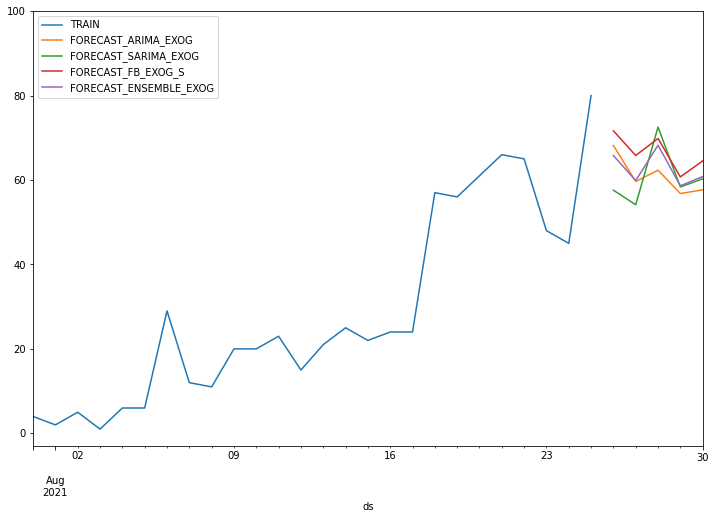

In [64]:
#Plotting all the models in uknown future
ax = vic_cases_wf_final["y"].plot()
ax.plot(arima_exog_forecast)
ax.plot(sarima_exog_forecast)
ax.plot(fb_exog_forecast_s)
ax.plot(ensemble_exog)
ax.set_xlim(date(2021,7,31),date(2021,8,30))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "FORECAST_ARIMA_EXOG","FORECAST_SARIMA_EXOG", "FORECAST_FB_EXOG_S", "FORECAST_ENSEMBLE_EXOG"]);

In [65]:
print(sarima_exog_forecast)

2021-08-26    57.587912
2021-08-27    54.143224
2021-08-28    72.531875
2021-08-29    58.351283
2021-08-30    60.285686
Freq: D, Name: predicted_mean, dtype: float64


In [66]:
print(arima_exog_forecast)

2021-08-26    68.174119
2021-08-27    59.652367
2021-08-28    62.319198
2021-08-29    56.797334
2021-08-30    57.673772
Freq: D, Name: predicted_mean, dtype: float64


In [67]:
print(ensemble_exog)

ds
2021-08-26    65.803751
2021-08-27    59.868122
2021-08-28    68.229959
2021-08-29    58.626541
2021-08-30    60.822479
dtype: float64


In [68]:
print(fb_exog_forecast_s)

                 yhat
ds                   
2021-08-26  71.649223
2021-08-27  65.808774
2021-08-28  69.838804
2021-08-29  60.731006
2021-08-30  64.507979


# 18 Lets try advanced model called neural prophet that uses AR-NET or neural networks for timeseries, another tool developed by facebook and uses pytorch as the backend

In [76]:
%%time
fb_neural_model = NeuralProphet(epochs=1000, n_forecasts=5, n_lags=3)
for _ in features:
    fb_neural_model.add_lagged_regressor(_)
fb_neural_metrics = fb_neural_model.fit(fb_full, freq='D')

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:nprophet.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [01:36<00:00, 10.40it/s, SmoothL1Loss=0.0248

CPU times: user 1min 35s, sys: 863 ms, total: 1min 36s
Wall time: 1min 36s


In [77]:
#Lets make predictions for the model
fb_neural_future = fb_neural_model.make_future_dataframe(df=fb_full, periods=test.shape[0])
for _ in features:
    fb_neural_future[_].iloc[-test.shape[0]:] = list(np.ones(test.shape[0]))
fb_neural_forecast = fb_neural_model.predict(fb_neural_future)
fb_neural_forecast.head()


/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_delta3,lagged_regressor_delta4,lagged_regressor_delta5,lagged_regressor_lockdown1,lagged_regressor_lockdown2,lagged_regressor_lockdown3,lagged_regressor_lockdown4,lagged_regressor_lockdown5,trend,season_weekly
0,2021-08-23,48,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
1,2021-08-24,45,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
2,2021-08-25,80,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
3,2021-08-26,None,64.402412,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,9.29219,None,None,None,None,-8.229537,0.573997
4,2021-08-27,None,None,NaN,61.552444,NaN,None,NaN,None,NaN,...,None,None,None,None,11.543432,None,None,None,-8.208108,-0.172364


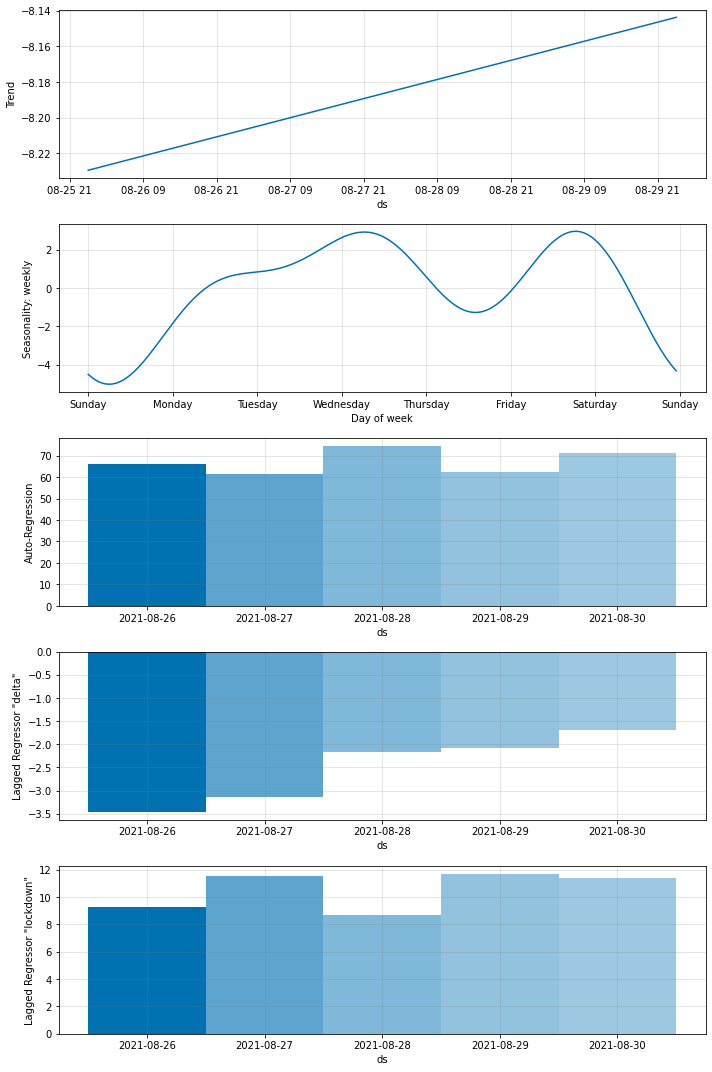

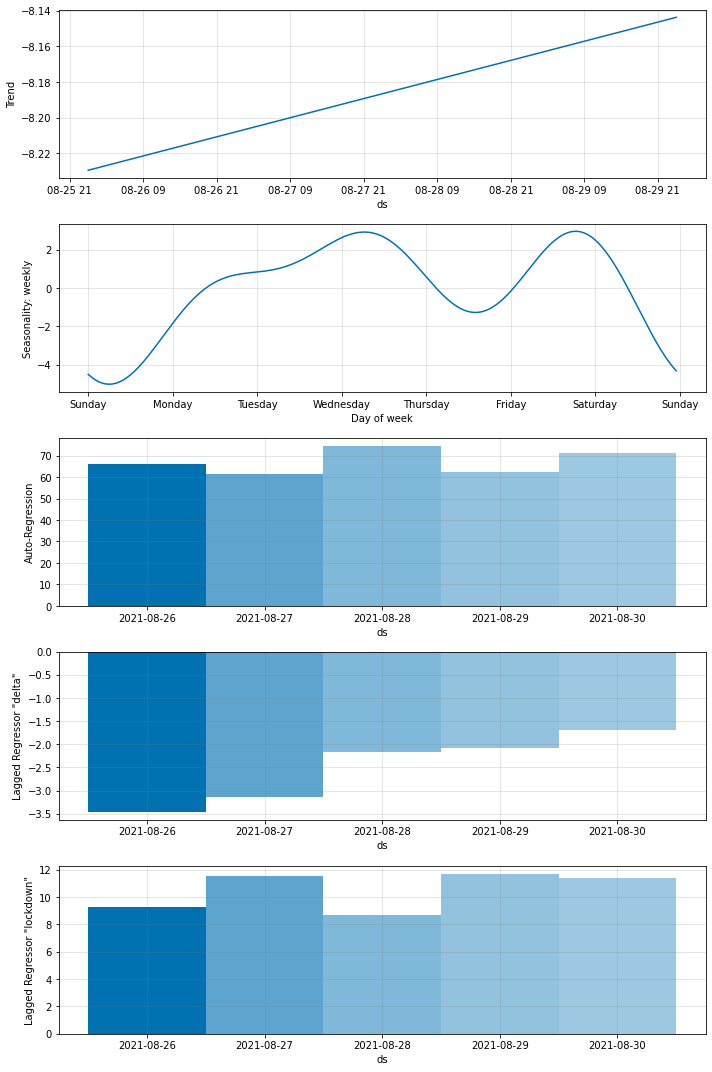

In [78]:
#Plotting the components
fb_neural_model.plot_components(fb_neural_forecast)

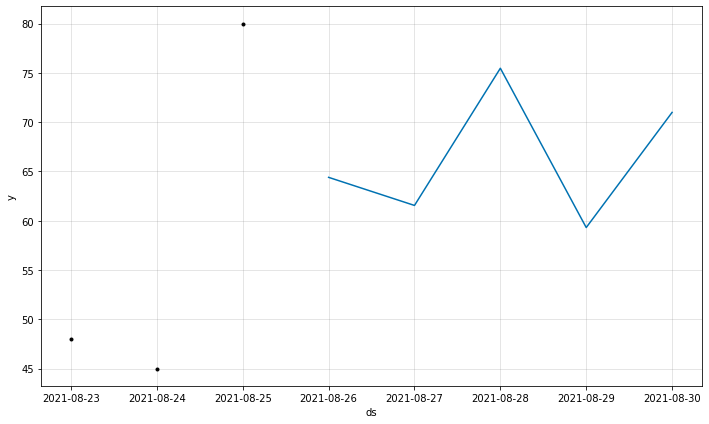

In [79]:
#Making the forecast plot
fb_neural_model.plot(fb_neural_forecast);

In [80]:
forecasts = []
for col in fb_neural_forecast.columns:
    if 'yhat' in col:
        forecasts.append([val for val in fb_neural_forecast[col] if val is not None][0])
forecast_df = fb_neural_forecast[["ds","y"]][-test.shape[0]:]
forecast_df.y = forecasts
forecast_df.set_index("ds", inplace=True)
forecast_df.head()

,y
ds,
2021-08-26,64.402412
2021-08-27,61.552444
2021-08-28,75.474213
2021-08-29,59.309135
2021-08-30,70.994530


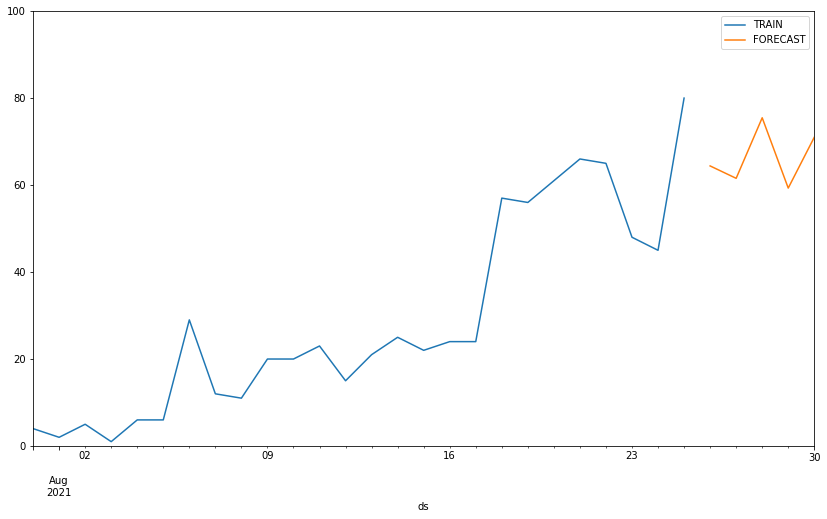

In [81]:
ax = vic_cases_wf_final["y"].plot(figsize=(14,8))
ax.plot(forecast_df["y"])
ax.set_xlim(date(2021,7,31), date(2021,8,30))
ax.set_ylim(0,100)
ax.legend(["TRAIN","FORECAST"]);

# 19 Are these any better than moving average models, why should we use or not use them? 